In [1]:
%load_ext autoreload
%autoreload 2

import opendp.prelude as dp
dp.enable_features("contrib")

d_in = 1 # input distance
input_metric = dp.symmetric_distance()

d_out = 1 # epsilon
privacy_measure = dp.max_divergence(T=float) # pure dp

# We don't really use what's left below in this code box
######################################################################################

col_names = [
   "name", "sex", "age", "maritalStatus", "hasChildren", "highestEducationLevel", 
   "sourceOfStress", "smoker", "optimism", "lifeSatisfaction", "selfEsteem"
]

import urllib.request
#data_url = "https://raw.githubusercontent.com/opendp/opendp/sydney/teacher_survey.csv"
#with urllib.request.urlopen(data_url) as data_req:
#    data = data_req.read().decode('utf-8')

# Make a queriable
m_sc = dp.c.make_sequential_composition(
    # data set is a single string, with rows separated by linebreaks
    input_domain=dp.atom_domain(T=str),
    input_metric=input_metric,
    output_measure=privacy_measure,
    d_in=d_in,
    d_mids=[d_out / 3] * 3,
)

#qbl_sc = m_sc(data)

import opendp as dpf

# Make a query
count_transformation = (
    dp.t.make_split_dataframe(",", col_names=col_names)
    >> dp.t.make_select_column("age", str)
    >> dp.t.then_count()
)
count_sensitivity = count_transformation.map(d_in)

# Add a Laplace measurement
laplace_scale = 1.0
count_laplace_measurement = count_transformation >> dp.m.then_laplace(scale=laplace_scale)
epsilon_laplace = count_laplace_measurement.map(count_sensitivity)
count_laplace_smooth_max_divergence_ms = dpf.combinators.make_zCDP_to_approxDP(dpf.combinators.make_pureDP_to_zCDP(count_laplace_measurement))
laplace_smd_curve = count_laplace_smooth_max_divergence_ms.map(count_sensitivity)

# Add a Gaussian measurement, transform to approximate DP and get SMDCurve
gaussian_scale = 1.0
count_gaussian_measurement = count_transformation >> dp.m.then_gaussian(scale = gaussian_scale)
count_gaussian_smooth_max_divergence_ms = dpf.combinators.make_zCDP_to_approxDP(count_gaussian_measurement)
gaussian_smd_curve = count_gaussian_smooth_max_divergence_ms.map(count_sensitivity)


from tradeoff import (
    support_tradeoff,
    approx_tradeoff, # alpha(beta), given n (epsilon, delta) pairs
    tradeoffCurve,   # alpha(beta), given privacy profile (computes then caches epsilon delta pairs),
    smdCurveWrapper  # utility for wrapping smdCurves
)

import scipy

from tradeoff import (
   tradeoff_gaussian,           # analytical gaussian tradeoff
   tradeoff_laplace,            # analytical laplace tradeoff
   get_tradeoff_gaussian,       # wrappers
   get_tradeoff_laplace,
   get_gaussian_privacy_profile, # analytical delta(epsilon)
   tradeoff_opt_gaussian          # optimization of the gaussian dual
)

from relative_risk import posterior, relative_risk

priors = [0.1, 0.2, 0.5, 0.9, 0.99]




In [2]:
import sys
import numpy as np
sys.path.append("../discrete-gaussian-differential-privacy")
from cdp2adp import (
    dg_delta
)
from tradeoff import dg_delta_k

alphas = np.arange(0, 1, 0.01)
deltas = np.arange(0.01, 1, 0.01)
privacy_profile_deltas = np.arange(0.01, 1, 0.01)
epsilons = np.concatenate((np.arange(0, 3, 0.01), np.arange(3, 30, 0.1)))

gaussian_mu = count_sensitivity / gaussian_scale

betas_gaussian_001 = tradeoffCurve(smdCurveWrapper(gaussian_smd_curve), deltas=privacy_profile_deltas)(alphas)
#betas_gaussian_00001 = tradeoffCurve(smdCurveWrapper(gaussian_smd_curve), deltas=np.arange(0.00001, 1, 0.00001))(alphas)
betas_gaussian_analytical = [tradeoff_gaussian(alpha, gaussian_mu) for alpha in alphas]
betas_gaussian_approx = tradeoffCurve(get_gaussian_privacy_profile(count_sensitivity, gaussian_scale), epsilons=epsilons)(alphas)
#betas_gaussian_approx_optimization = [tradeoff_opt_gaussian(alpha, get_gaussian_privacy_profile(count_sensitivity, gaussian_scale)) for alpha in alphas]
betas_gaussian_dg_analytical = [tradeoffCurve((lambda e: dg_delta(gaussian_scale**2, e, count_sensitivity)), epsilons=epsilons)(alpha) for alpha in alphas]
betas_gaussian_dg_analytical_k = [tradeoffCurve((lambda e: dg_delta_k(gaussian_scale**2, e, count_sensitivity, k=-4)), epsilons=epsilons)(alpha) for alpha in alphas]

#privacy_profile_gaussian_approx_epsilons = [gaussian_smd_curve.epsilon(delta) for delta in privacy_profile_deltas]
#privacy_profile_gaussian_analytical_deltas = [get_gaussian_privacy_profile(count_sensitivity, gaussian_scale)(eps) for eps in epsilons]
#privacy_profile_gaussian_discrete_deltas = [(lambda e: dg_delta(gaussian_scale**2, e, count_sensitivity, iters=2000))(eps) for eps in epsilons]
#privacy_profile_gaussian_discrete_deltas_k = [(lambda e: dg_delta_k(gaussian_scale**2, e, count_sensitivity, iters=2000, k=-4))(eps) for eps in epsilons]

In [3]:
tradeoff_approx_gaussian = tradeoffCurve(smdCurveWrapper(gaussian_smd_curve), deltas=deltas)
posteriors_gaussian = []
for prior in priors:
    post = [posterior(alpha, tradeoff_approx_gaussian, prior) for alpha in alphas]
    posteriors_gaussian.append(post)

posteriors_analytical_gaussian = []
for prior in priors:
    post = [posterior(alpha, get_tradeoff_gaussian(mu=gaussian_mu), prior) for alpha in alphas]
    posteriors_analytical_gaussian.append(post)

tradeoff_discrete_gaussian = tradeoffCurve((lambda e: dg_delta(gaussian_scale**2, e, count_sensitivity, iters=2000)), epsilons=epsilons)
posteriors_discrete_gaussian = []
for prior in priors:
    post = [posterior(alpha, tradeoff_discrete_gaussian, prior) for alpha in alphas]
    posteriors_discrete_gaussian.append(post)

tradeoff_discrete_gaussian_k4 = tradeoffCurve((lambda e: dg_delta_k(gaussian_scale**2, e, count_sensitivity, iters=2000, k=-4)), epsilons=epsilons)
posteriors_discrete_gaussian_4k = []
for prior in priors:
    post = [posterior(alpha, tradeoff_discrete_gaussian_k4, prior) for alpha in alphas]
    posteriors_discrete_gaussian_4k.append(post)

/mnt/data/research/opendp/opendp-relative-risk/relative_risk.py:5: RuntimeWarning: invalid value encountered in scalar divide
  posterior = (prior * (1 - beta)) / ((1 - prior)*alpha + prior * (1 - beta))


In [4]:
tradeoff_approx_gaussian = tradeoffCurve(smdCurveWrapper(gaussian_smd_curve), deltas=deltas)
rrisk_gaussian = []
for prior in priors:
    rrsisk = [relative_risk(alpha, tradeoff_approx_gaussian, prior) for alpha in alphas]
    rrisk_gaussian.append(rrsisk)

rrisk_analytical_gaussian = []
for prior in priors:
    rrsisk = [relative_risk(alpha, get_tradeoff_gaussian(mu=gaussian_mu), prior) for alpha in alphas]
    rrisk_analytical_gaussian.append(rrsisk)

tradeoff_discrete_gaussian = tradeoffCurve((lambda e: dg_delta(gaussian_scale**2, e, count_sensitivity, iters=2000)), epsilons=epsilons)
rrisk_discrete_gaussian = []
for prior in priors:
    rrsisk = [relative_risk(alpha, tradeoff_discrete_gaussian, prior) for alpha in alphas]
    rrisk_discrete_gaussian.append(rrsisk)

tradeoff_discrete_gaussian_k4 = tradeoffCurve((lambda e: dg_delta_k(gaussian_scale**2, e, count_sensitivity, iters=2000, k=-4)), epsilons=epsilons)
rrisk_discrete_gaussian_k4 = []
for prior in priors:
    rrsisk = [relative_risk(alpha, tradeoff_discrete_gaussian_k4, prior) for alpha in alphas]
    rrisk_discrete_gaussian_k4.append(rrsisk)

/mnt/data/research/opendp/opendp-relative-risk/relative_risk.py:12: RuntimeWarning: invalid value encountered in scalar divide
  relative_risk = (1 - beta) / ((1 - prior)*alpha + prior * (1 - beta))


In [5]:
from tradeoff import pure_dp_privacy_profile, get_laplace_privacy_profile

betas_laplace_001 = tradeoffCurve(smdCurveWrapper(laplace_smd_curve), deltas=privacy_profile_deltas)(alphas)
betas_laplace_analytical = [tradeoff_laplace(alpha, laplace_scale, count_sensitivity) for alpha in alphas]
meier_epsilons = np.arange(0.5, 1.5, 0.001)
betas_laplace_meier_conversion = tradeoffCurve((lambda e: pure_dp_privacy_profile(epsilon_laplace, e)), epsilons=meier_epsilons)(alphas)
betas_laplace_support_curve = [support_tradeoff(alpha, epsilon_laplace, 0) for alpha in alphas]
betas_laplace_privacy_profile = tradeoffCurve(get_laplace_privacy_profile(count_sensitivity, laplace_scale), epsilons=epsilons)(alphas)

#privacy_profile_laplace_approx_epsilons = [laplace_smd_curve.epsilon(delta) for delta in privacy_profile_deltas]
#privacy_profile_gaussian_analytical_deltas = [get_gaussian_privacy_profile(count_sensitivity, gaussian_scale)(eps) for eps in epsilons]

In [6]:
posteriors_laplace = []

tradeoff_laplace_eps1 = tradeoffCurve(smdCurveWrapper(laplace_smd_curve), deltas=deltas)

for prior in priors:
    post = [posterior(alpha, tradeoff_laplace_eps1, prior) for alpha in alphas]
    posteriors_laplace.append(post)


posteriors_analytical_laplace = []
for prior in priors:
    post = [posterior(alpha, get_tradeoff_laplace(scale=laplace_scale, sensitivity=count_sensitivity), prior) for alpha in alphas]
    posteriors_analytical_laplace.append(post)

posteriors_support_laplace = []
tradeoff_laplace_support = (lambda alpha: support_tradeoff(alpha, epsilon_laplace, 0))
for prior in priors:
    post = [posterior(alpha, tradeoff_laplace_support, prior) for alpha in alphas]
    posteriors_support_laplace.append(post)


In [7]:
alphas = np.arange(0, 1, 0.01)
deltas = np.arange(0.001, 1, 0.001)
priors = [0.1, 0.2, 0.5, 0.9, 0.99]

tradeoff_laplace_eps1 = tradeoffCurve(smdCurveWrapper(laplace_smd_curve), deltas=deltas)

rrisk_laplace = []
for prior in priors:
    rrisk = [relative_risk(alpha, tradeoff_laplace_eps1, prior) for alpha in alphas]
    rrisk_laplace.append(rrisk)


rrisk_analytical_laplace = []
for prior in priors:
    rrisk = [relative_risk(alpha, get_tradeoff_laplace(scale=laplace_scale, sensitivity=count_sensitivity), prior) for alpha in alphas]
    rrisk_analytical_laplace.append(rrisk)

rrisk_support_laplace = []
for prior in priors:
    rrisk = [relative_risk(alpha, tradeoff_laplace_support, prior) for alpha in alphas]
    rrisk_support_laplace.append(rrisk)


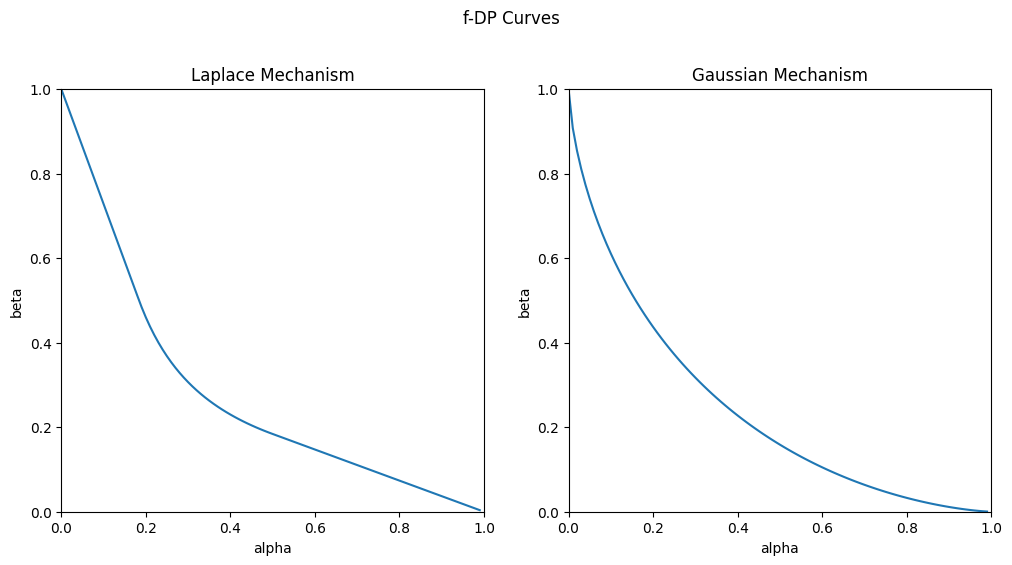

In [13]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle("f-DP Curves")

ax1.plot(alphas, betas_laplace_analytical)
ax1.set_xlabel('alpha')
ax1.set_ylabel('beta')
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)
ax1.set_title('Laplace Mechanism')
#ax1.legend()
ax1.set_aspect('equal')

ax2.plot(alphas, betas_gaussian_analytical)
ax2.set_xlabel('alpha')
ax2.set_ylabel('beta')
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 1)
ax2.set_title('Gaussian Mechanism')
#ax2.legend()
ax2.set_aspect('equal')





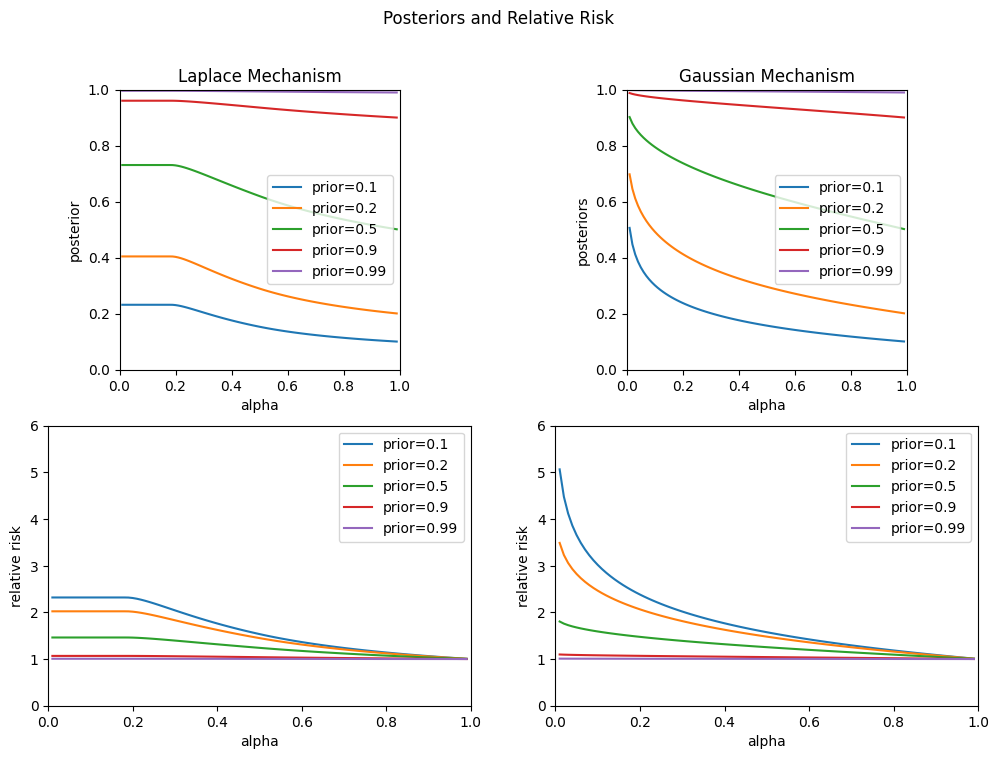

In [9]:
import matplotlib.pyplot as plt

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle("Posteriors and Relative Risk")

for i in range(len(priors)):
    ax1.plot(alphas, posteriors_analytical_laplace[i], label=f"prior={priors[i]}")
ax1.set_xlabel('alpha')
ax1.set_ylabel('posterior')
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)
ax1.set_title('Laplace Mechanism')
ax1.legend()
ax1.set_aspect('equal')

for i in range(len(priors)):
    ax2.plot(alphas, posteriors_analytical_gaussian[i], label=f"prior={priors[i]}")
ax2.set_xlabel('alpha')
ax2.set_ylabel('posteriors')
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 1)
ax2.set_title('Gaussian Mechanism')
ax2.legend()
ax2.set_aspect('equal')

for i in range(len(priors)):
    ax3.plot(alphas, rrisk_analytical_laplace[i], label=f"prior={priors[i]}")
ax3.set_xlabel('alpha')
ax3.set_ylabel('relative risk')
ax3.set_xlim(0, 1)
ax3.set_ylim(0, 6)
ax3.legend()
#ax3.set_aspect('equal')

for i in range(len(priors)):
    ax4.plot(alphas, rrisk_analytical_gaussian[i], label=f"prior={priors[i]}")
ax4.set_xlabel('alpha')
ax4.set_ylabel('relative risk')
ax4.set_xlim(0, 1)
ax4.set_ylim(0, 6)
ax4.legend()
#ax3.set_aspect('equal')




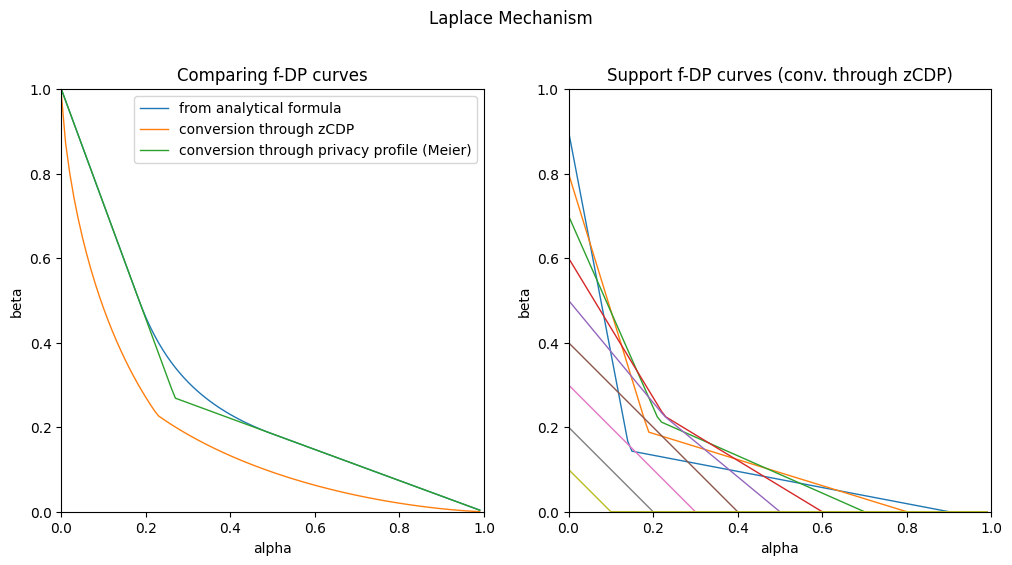

In [27]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle("Laplace Mechanism")

# from smdCurve vs analytical
ax1.plot(alphas, betas_laplace_analytical, label='from analytical formula', marker='', linewidth=1)
ax1.plot(alphas, betas_laplace_001, label='conversion through zCDP', marker='', linewidth=1)
#ax1.plot(alphas, betas_laplace_privacy_profile, label='conversion through privacy profile', marker='', linewidth=1)
ax1.plot(alphas, betas_laplace_meier_conversion, label='conversion through privacy profile (Meier)', marker='', linewidth=1)
ax1.set_xlabel('alpha')
ax1.set_ylabel('beta')
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)
ax1.set_title('Comparing f-DP curves')
ax1.legend()
ax1.set_aspect('equal')

# Support lines
for delta in np.arange(0.1, 1, 0.1):
    betas_eps_delta = [support_tradeoff(alpha, laplace_smd_curve.epsilon(delta), delta) for alpha in alphas]
    ax2.plot(alphas, betas_eps_delta, label=f"f-eps-delta({delta})", marker="", linewidth=1)
ax2.set_xlabel('alpha')
ax2.set_ylabel('beta')
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 1)
ax2.set_title('Support f-DP curves (conv. through zCDP)')
#ax2.legend()
ax2.set_aspect('equal')

# TODO shift f-dp curves

plt.show()
